# **Algoritmo para filtragem de dados provenientes de séries temporais do MODIS**

**SER347 - Introdução à Programação para Sensoriamento Remoto**

Integrantes: Bruno Matosak, Marcos Rodrigues e Tatiana Uehara









# 1. Objetivo

O presente trabalho teve como objetivo a criação de uma ferramenta em Python com interface gráfica, para a obtenção e processamento de dados de séries temporais MODIS (MOD13Q1).


# 2. Pré-Requisitos

Conexão com a internet.

O script necessita dos seguintes pacotes para Python 3:

- gi (Gtk e GObject, versão 3.0)
- sys
- matplotlib
- wtss*
- numpy
- datetime
- csv
- scipy
- math
 
(Informações sobre a biblioteca wtss podem ser encontradas neste link: https://github.com/e-sensing/wtss.py)

# 3. Produtos Utilizados

As seguintes séries estão disponíveis até o momento:

MOD13Q1 (dados dos produtos MODIS)

- mir (middle infrared)
- blue
- nir (near infrared)
- red
- evi (Enhanced Vegetation Index )
- ndvi (Normalized Difference Vegetation Index )

MOD13Q1_M (dados de qualidade)

- quality
- reliability (confiabilidade)

Disponibiliza-se dois tipos de gráficos a serem plotados:

- Linha
- Polar

# 4. Demonstração do programa

# 5. Filtros
O script oferece 5 opções de aplições de filtros, sendo elas:

- Filtro de média
- Filtro de pirâmide
- Filtro de Gauss
- Filtro de Savitzky-Golay
- Filtro de Whittaker-Eilers





No **filtro de média**, o parâmetro de entrada é apenas o tamanho da janela de filtragem. Dentro da janela, o centro é estabelecido no valor a ser filtrado e, então, feita a média para os valores adjacentes.



In [0]:
    def filter_mean(self, ts):
        ts_filtered = ts.copy()
        global window_size_mean
        n_p = int((window_size_mean-1)/2)

        for j in range(n_p, len(ts_filtered) - n_p):
            ts_filtered[j] = np.mean(ts[(j-n_p):(j+n_p+1)])

        return ts_filtered

No **filtro de pirâmide** é feita uma média ponderada dos termos. O único parâmetro de entrada é o tamanho da janela de pesos da filtragem, a qual é definida seguindo um modelo de pirâmide. O primeiro termo tem peso igual a 1, o seguinte termo tem seu peso acrescido de 1 em relação ao anterior, e assim por diante até o termo do centro da janela, a partir do qual começa-se a subtrair 1 do peso anterior para a definição do peso subsequente. O termo central (de maior peso) é usado para o termo a ser filtrado e os termos adjacentes da janela são usados como pesos para os termos adjacentes ao valor filtrado.

In [0]:
  def filter_pyramid(self, ts):
        ts_filtered = ts.copy()
        global window_size_pyramid
        n_p = int((window_size_mean-1)/2)

        for j in range(n_p, len(ts_filtered) - n_p):
            ts_filtered[j] = 0.
            for i in range(-1 * n_p, n_p + 1):
                ts_filtered[j] = ts_filtered[j] + (abs(abs(i) - (n_p + 1)) * ts[j + i] / ((n_p + 1) ** 2))

        return ts_filtered

O **filtro de Gauss** funciona de forma muito semelhante ao filtro de pirâmide, porém, a definição dos pesos da janela de filtragem é feita através de uma função do tipo Gaussiana. Os parâmetros de entrada são o tamanho da janela de filtragem e o desvio padrão para a função gaussiana.


In [0]:
from google.colab import files
from IPython.display import Image
uploaded = files.upload()

Saving matriz.png to matriz (4).png


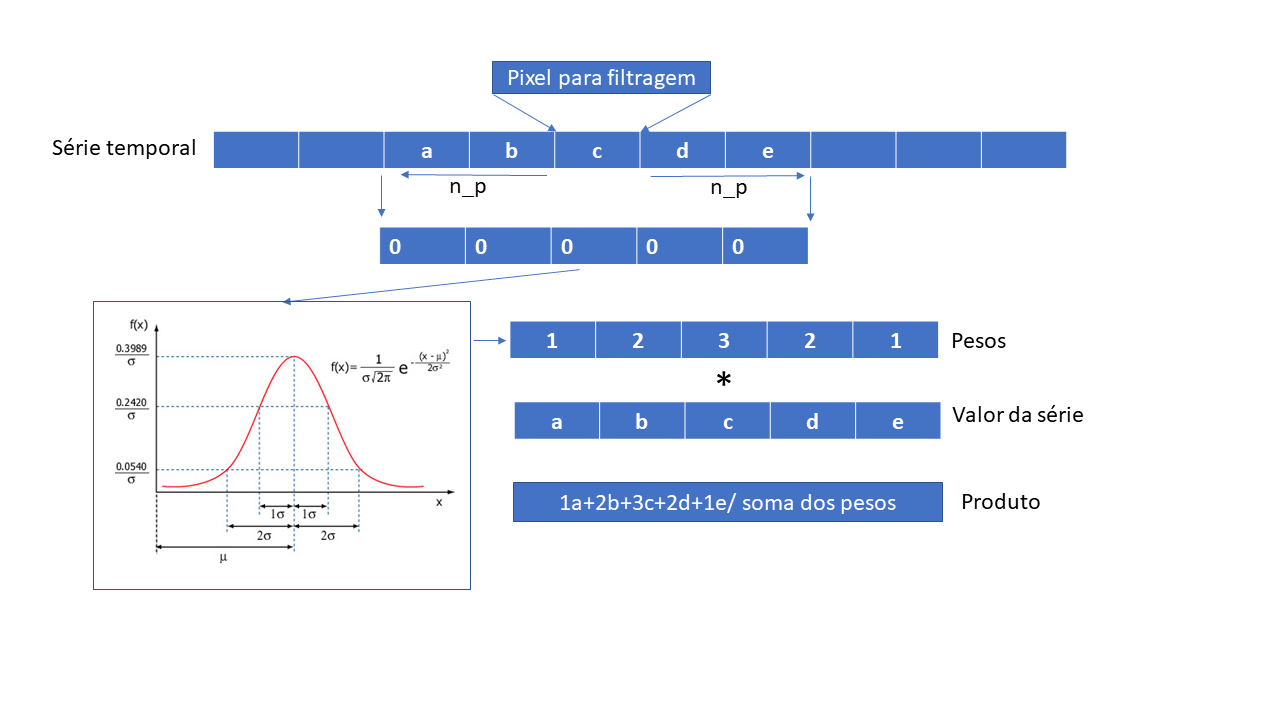

In [0]:
Image('matriz (4).png',
     width = 1000)

In [0]:
  # DISTRIBUIÇÃO NORMAL GAUSSIANA:
  
  def filter_gauss(self, time_series):

        ts_filtered = time_series.copy()
        global window_size_GA
        global sigma_GA
        mi = 0

        n_p = int((window_size_GA - 1) / 2)

        # defining the mask
        mask = np.zeros(window_size_GA)
        for t in range(-n_p, n_p + 1):
            mask[t + n_p] = float(
                (1 / (sigma_GA * math.sqrt(2 * math.pi))) * math.e ** ((-1 / 2) * (((t - mi) ** 2) / sigma_GA ** 2)))

        for j in range(n_p, len(time_series) - n_p):
            a = np.asarray(time_series[j - n_p:j + n_p + 1])
            soma = np.sum(np.asarray(mask) * a)
            ts_filtered[j] = soma / np.sum(mask)
        return ts_filtered

O filtro de **Savitzky-Golay** é descrito no artigo abaixo. Os parâmetros de entrada são o tamanho da janela de filtragem, a ordem do polinômio de ajuste, a ordem da derivada e a taxa.
<https://pubs.acs.org/doi/pdf/10.1021/ac60214a047>


O filtro de **Whittaker-Eilers** é descrito de forma completa no artigo abaixo. Os parâmetros de entrada são o tamanho da janela de filtragem e a agressividade da filtragem. <https://pubs.acs.org/doi/abs/10.1021/ac034173t>




**Remoção de Outliers**
Caso detectada a ocorrência de um outlier na série, este é substituído pela interpolação simples de seus vizinhos imediatos à esquerda e direita. Artigo de referência: <https://www.mdpi.com/2072-4292/5/12/6159>

O processo necessita apenas de um parâmetro de entrada: a porcentagem limiar da diferença para com seus vizinhos. O valor padrão é 1%, e para alterá-lo basta que o usuário acesse o item "Settings" da barra de menu, e em seguida o item "Outliers Removal". A figura a seguir demosntra a janela de alteração dos parâmtros de remoção de outliers.


In [0]:
    def remove_outliers(self, ts):
        ts_corrected = ts.copy()
        global percent_outliers_removal
        per = percent_outliers_removal/100

        for j in range(1, len(ts_corrected) - 1):
            if (ts[j]-ts[j-1]<-per*ts[j-1]) and (ts[j]-ts[j+1]<-per*ts[j+1]):
                ts_corrected[j] = (ts[j-1]+ts[j+1])/2

        return ts_corrected

# 5. Armazenamento de dados:

Disponibiliza salvar os dados em uma tabela do tipo ".csv".
Notar o uso do método de fatiamento e adição de string.


In [0]:
    def save_data(self, dialog, response_id, tline, data_raw, f_pyramid, f_mean, f_gauss, f_outlier, f_SG, f_WT_E, coverage, series, lat, long):

        save_dialog = dialog
        # if response is "ACCEPT" (the button "Save" has been clicked)
        if response_id == Gtk.ResponseType.ACCEPT:
            # self.file is the currently selected file
            file_name = save_dialog.get_filename()

            if file_name[-4:] != ".csv" and file_name[-4:] != ".CSV":
                file_name = file_name+".csv"


#6. Gráficos: Linha e Polar

In [0]:
            def polar(tline, data_raw):
                jdates = tline.copy()
                # julian days
                for i in range(len(jdates)):
                    jdates[i] = (datetime.datetime.combine(jdates[i], datetime.datetime.min.time())).timetuple().tm_yday
                jdates = np.asarray(jdates).astype(np.float)
                a = jdates.copy()
                o = jdates.copy()
                for i in range(len(jdates)):
                    a[i] = float(data_raw[i] * np.cos(2 * np.pi * jdates[i] / 365.0))
                    o[i] = float(data_raw[i] * np.sin(2 * np.pi * jdates[i] / 365.0))
                return a, o


# 4. Agradecimentos
Os autores gostariam de agradecer ao Prof. Gilberto Ribeiro de Queiroz, pelo auxílio quanto ao uso da biblioteca wtss.

Os autores agradecem também ao usuário do GitHub mhvwerts, pela ajuda na implementação do código da filtragem de Savitzky-Golay.